# 秒足アノマリーの検証

### 1. Libraries import

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np 
from datetime import datetime


### 2. Data import <br>
秒足の作成は多分約定履歴からできたはず。

In [ ]:
df = pd.read_csv('data/trades_20250508_165631.csv')
df.head()

,timestamp,coin,side,price,size,time,tid
0,2025-05-09T17:28:20.072748,BTC,B,103066.0,0.00800,1746811699928,579906322026067
1,2025-05-09T17:28:20.220388,BTC,B,103066.0,0.00123,1746811700022,5110611355426
2,2025-05-09T17:28:20.220388,BTC,B,103066.0,0.03050,1746811700022,1065223385044199
3,2025-05-09T17:28:21.573582,BTC,B,103060.0,0.00015,1746811701167,1019402657194214
4,2025-05-09T17:28:21.573582,BTC,B,103061.0,0.00015,1746811701167,778287796785081


A = Ask, B = Bid

In [6]:
#Timestamp型に変換
df["timestamp"] = pd.to_datetime(df["timestamp"])

5秒ごとにリサンプリング

In [ ]:
#timestampをindexに。
df = df.set_index("timestamp")
# priceのOHLCとsizeの合計（volume）を計算
ohlcv_5s = df.resample("5S").agg({
    "price": ["first", "max", "min", "last"],
    "size": "sum"
})
# 列名を整える
ohlcv_5s.columns = ["open", "high", "low", "close", "volume"]
ohlcv_5s = ohlcv_5s.dropna()  # 欠損がある行を除く

ohlcv_5s.head()

/var/folders/z4/bxy8mrf91mj58fjgr1bc1jmc0000gn/T/ipykernel_69883/520937411.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ohlcv_5s = df.resample("5S").agg({


,open,high,low,close,volume
timestamp,,,,,
2025-05-09 17:28:20,103066.0,103066.0,103028.0,103059.0,12.18001
2025-05-09 17:28:25,103059.0,103060.0,103059.0,103060.0,0.69461
2025-05-09 17:28:30,103059.0,103060.0,103059.0,103059.0,0.28126
2025-05-09 17:28:35,103059.0,103077.0,103059.0,103077.0,0.03900
2025-05-09 17:28:40,103077.0,103077.0,103066.0,103066.0,0.03200


### 3. ローソク足の確認 <br>
ローソク足プロット用コード：

In [9]:
def plot_ohlc(df, sec=300, title=''):
    # secには、描画しようとしている足の秒数を指定.
    # 1分足 -> 60
    # 1時間足 -> 60 * 60 など.
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.grid(color='#eeeeee')
    ax.set_title(title)
    # ローソク足の幅を設定
    # matplotlib上でwidth=1->1日となるのでローソク足の時間軸に応じて幅を設定
    w = sec / (24 * 60 * 60)
    # ローソク足
    # 陽線と陰線で色を変えるため、それぞれのindexを取得
    idx1 = df.index[df['close'] > df['open']]
    idx0 = df.index[df['close'] < df['open']]
    idx2 = df.index[df['close'] == df['open']]
    # 実体
    df['body'] = np.abs(df['close'] - df['open'])
    ax.bar(idx1, df.loc[idx1, 'body'], width=w * (1 - 0.2), bottom=df.loc[idx1, 'open'], linewidth=1, color='#4caf50', zorder=2)
    ax.bar(idx0, df.loc[idx0, 'body'], width=w * (1 - 0.2), bottom=df.loc[idx0, 'close'], linewidth=1, color='#f23645', zorder=2)
    ax.bar(idx2, df.loc[idx2, 'body'], width=w * (1 - 0.2), bottom=df.loc[idx2, 'close'], linewidth=1, color='#666666', zorder=2)
    # ヒゲ
    # ax.vlines(df.index, df['low_perp'], df['high_perp'], linewidth=0.5, color='#666666', zorder=1)
    ax.vlines(idx1, df.loc[idx1, 'low'], df.loc[idx1, 'high'], linewidth=0.5, color='#4caf50', zorder=1)
    ax.vlines(idx0, df.loc[idx0, 'low'], df.loc[idx0, 'high'], linewidth=0.5, color='#f23645', zorder=1)
    ax.vlines(idx2, df.loc[idx2, 'low'], df.loc[idx2, 'high'], linewidth=0.5, color='#666666', zorder=1)
    ax.set_ylabel("PRICE")

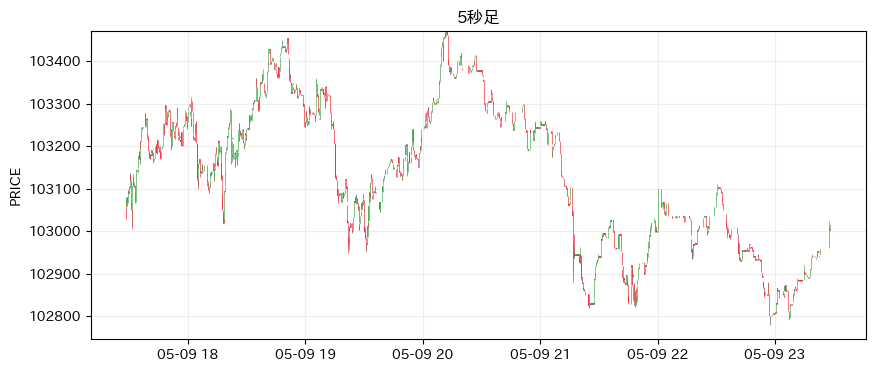

In [10]:
plt.figure(figsize=(10, 4))
plot_ohlc(ohlcv_5s, sec=5, title='5秒足')

最初の30分

/var/folders/z4/bxy8mrf91mj58fjgr1bc1jmc0000gn/T/ipykernel_69883/100852652.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['body'] = np.abs(df['close'] - df['open'])


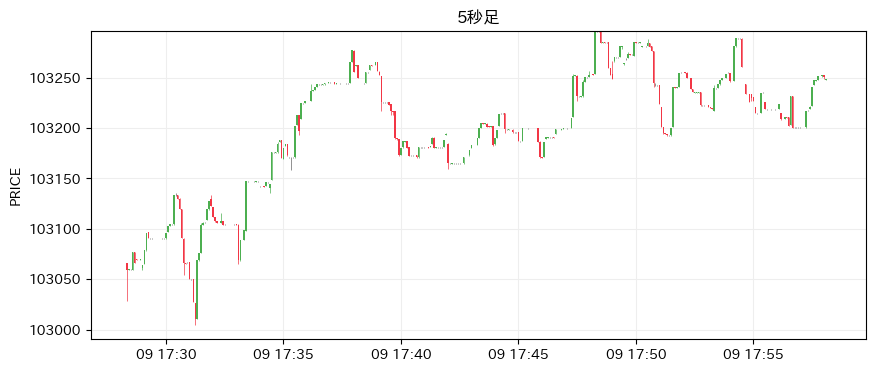

In [12]:
plt.figure(figsize=(10, 4))
plot_ohlc(ohlcv_5s[:12*30], sec=5, title='5秒足');

### 4. 色々基本の計算

In [13]:
ohlcv_5s['ror'] = (ohlcv_5s['close'] - ohlcv_5s['open']) / ohlcv_5s['open']

相関プロット用コード

In [14]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

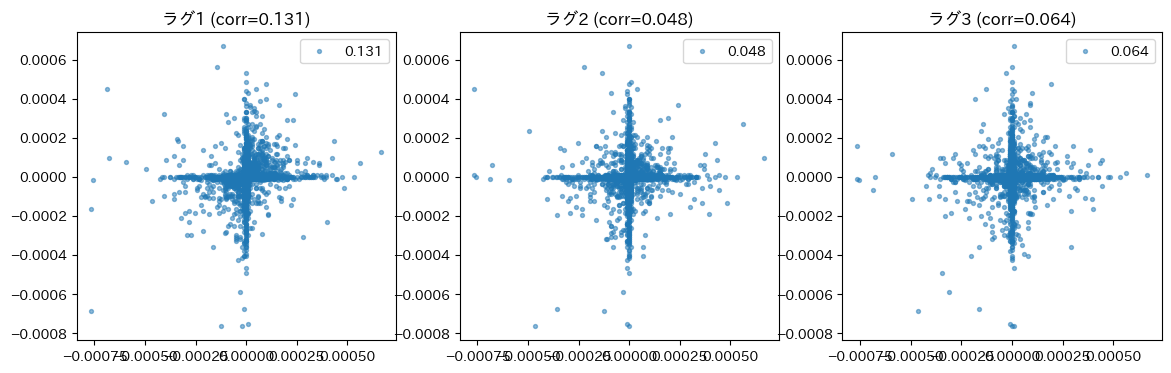

In [15]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plot_corr(ohlcv_5s['ror'].shift(1), ohlcv_5s['ror'], title='ラグ1')
plt.subplot(1, 3, 2)
plot_corr(ohlcv_5s['ror'].shift(2), ohlcv_5s['ror'], title='ラグ2')
plt.subplot(1, 3, 3)
plot_corr(ohlcv_5s['ror'].shift(3), ohlcv_5s['ror'], title='ラグ3');

うっすら正の相関？

In [16]:
tmp = ohlcv_5s.copy()
tmp['abs_ror'] = np.abs(tmp['ror'])
tmp['sec'] = tmp.index.second

In [17]:
tmp

,open,high,low,close,volume,body,ror,abs_ror,sec
timestamp,,,,,,,,,
2025-05-09 17:28:20,103066.0,103066.0,103028.0,103059.0,12.18001,7.0,-0.000068,0.000068,20
2025-05-09 17:28:25,103059.0,103060.0,103059.0,103060.0,0.69461,1.0,0.000010,0.000010,25
2025-05-09 17:28:30,103059.0,103060.0,103059.0,103059.0,0.28126,0.0,0.000000,0.000000,30
2025-05-09 17:28:35,103059.0,103077.0,103059.0,103077.0,0.03900,18.0,0.000175,0.000175,35
2025-05-09 17:28:40,103077.0,103077.0,103066.0,103066.0,0.03200,11.0,-0.000107,0.000107,40
...,...,...,...,...,...,...,...,...,...
2025-05-09 23:28:00,103007.0,103007.0,103006.0,103006.0,0.00394,1.0,-0.000010,0.000010,0
2025-05-09 23:28:05,103007.0,103007.0,103007.0,103007.0,2.00111,0.0,0.000000,0.000000,5
2025-05-09 23:28:10,103007.0,103008.0,103007.0,103008.0,5.75100,1.0,0.000010,0.000010,10


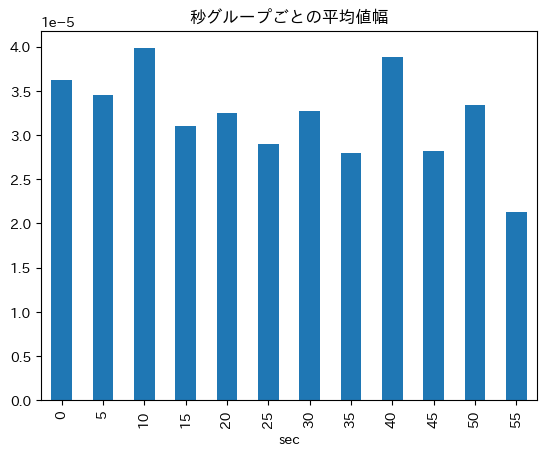

In [18]:
tmp.groupby('sec')['abs_ror'].mean().plot(kind='bar', title='秒グループごとの平均値幅');

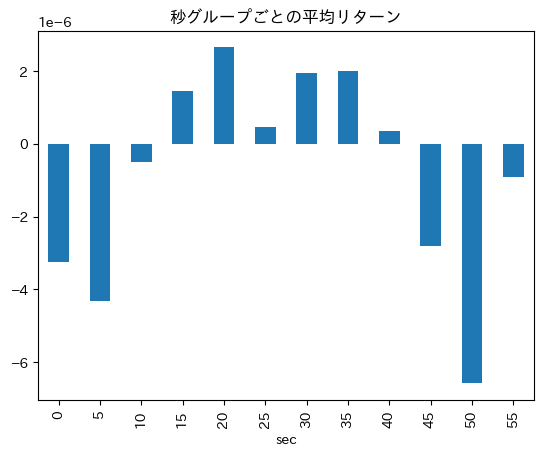

In [19]:
tmp.groupby('sec')['ror'].mean().plot(kind='bar', title='秒グループごとの平均リターン');

In [20]:
tmp

,open,high,low,close,volume,body,ror,abs_ror,sec
timestamp,,,,,,,,,
2025-05-09 17:28:20,103066.0,103066.0,103028.0,103059.0,12.18001,7.0,-0.000068,0.000068,20
2025-05-09 17:28:25,103059.0,103060.0,103059.0,103060.0,0.69461,1.0,0.000010,0.000010,25
2025-05-09 17:28:30,103059.0,103060.0,103059.0,103059.0,0.28126,0.0,0.000000,0.000000,30
2025-05-09 17:28:35,103059.0,103077.0,103059.0,103077.0,0.03900,18.0,0.000175,0.000175,35
2025-05-09 17:28:40,103077.0,103077.0,103066.0,103066.0,0.03200,11.0,-0.000107,0.000107,40
...,...,...,...,...,...,...,...,...,...
2025-05-09 23:28:00,103007.0,103007.0,103006.0,103006.0,0.00394,1.0,-0.000010,0.000010,0
2025-05-09 23:28:05,103007.0,103007.0,103007.0,103007.0,2.00111,0.0,0.000000,0.000000,5
2025-05-09 23:28:10,103007.0,103008.0,103007.0,103008.0,5.75100,1.0,0.000010,0.000010,10


In [23]:
import pandas as pd
from scipy import stats

# agg の中で lambda を使って t 値／p 値を取得
t_p_df = tmp.groupby('sec').agg(
    t_stat = ('ror', lambda x: stats.ttest_1samp(x, 0).statistic),
    p_value = ('ror', lambda x: stats.ttest_1samp(x, 0).pvalue)
)

# フィルタ
signif = t_p_df[t_p_df['p_value'] < 0.05]
print(signif)

Empty DataFrame
Columns: [t_stat, p_value]
Index: []


In [24]:
print(t_p_df)

       t_stat   p_value
sec                    
0   -0.804807  0.421463
5   -1.046771  0.295910
10  -0.108322  0.913803
15   0.389894  0.696846
20   0.584911  0.558974
25   0.111898  0.910967
30   0.496664  0.619730
35   0.488141  0.625751
40   0.068923  0.945091
45  -0.764219  0.445239
50  -1.506461  0.132828
55  -0.325931  0.744669


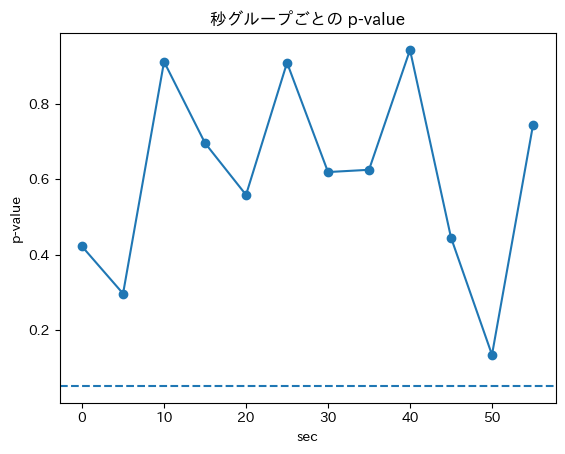

In [ ]:
plt.figure()
plt.plot(t_p_df.index, t_p_df['p_value'], marker='o')
plt.axhline(0.05, linestyle='--')
plt.xlabel('sec')
plt.ylabel('p-value')
plt.title('秒グループごとの p-value')
plt.show()

何もない、秒足アノマリーは消えた

一応バックテスト

In [28]:
def backtest_short_40_to_5(tmp):
    """
    tmp: index が datetime, 列に ['open','close','sec'] を持つ DataFrame
    sec == 40 でショート・エントリー、次の sec == 5 で決済
    """
    entry_times = tmp[tmp['sec'] == 40].index
    trades = []

    for t0 in entry_times:
        entry_price = tmp.at[t0, 'open']
        # t0 より後で最初に sec==5 の行を探す
        future = tmp.loc[t0:]
        exit_rows = future[future['sec'] == 5]
        if exit_rows.empty:
            continue
        t1 = exit_rows.index[0]
        exit_price = tmp.at[t1, 'open']
        r = (entry_price - exit_price) / entry_price  # ショート PnL
        trades.append({
            'entry_time':  t0,
            'exit_time':   t1,
            'entry_price': entry_price,
            'exit_price':  exit_price,
            'ror':         r
        })

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        print("No trades executed.")
        return trades_df

    trades_df['simple_pnl'] = trades_df['ror']
    trades_df['cum_return'] = (1 + trades_df['ror']).cumprod() - 1

    print(f"Number of trades: {len(trades_df)}")
    print(f"Total simple PnL: {trades_df['simple_pnl'].sum():.6f}")
    print(f"Total compounded return: {trades_df['cum_return'].iloc[-1]:.6f}")

    return trades_df

# 実行例
trades_df = backtest_short_40_to_5(tmp)
print(trades_df)

Number of trades: 346
Total simple PnL: 0.002595
Total compounded return: 0.002592
             entry_time           exit_time  entry_price  exit_price  \
0   2025-05-09 17:28:40 2025-05-09 17:29:05     103077.0    103065.0   
1   2025-05-09 17:29:40 2025-05-09 17:30:05     103091.0    103097.0   
2   2025-05-09 17:30:40 2025-05-09 17:31:05     103120.0    103050.0   
3   2025-05-09 17:31:40 2025-05-09 17:32:05     103107.0    103112.0   
4   2025-05-09 17:32:40 2025-05-09 17:33:05     103105.0    103104.0   
..                  ...                 ...          ...         ...   
341 2025-05-09 23:18:40 2025-05-09 23:19:05     102936.0    102940.0   
342 2025-05-09 23:20:40 2025-05-09 23:21:05     102939.0    102940.0   
343 2025-05-09 23:21:40 2025-05-09 23:22:05     102940.0    102952.0   
344 2025-05-09 23:23:40 2025-05-09 23:24:05     102959.0    102959.0   
345 2025-05-09 23:27:40 2025-05-09 23:28:05     102973.0    103007.0   

          ror  simple_pnl  cum_return  
0    0.00011

In [29]:
win_rate = (trades_df['ror'] > 0).mean()

# 2. 平均利幅／平均損幅
avg_win  = trades_df.loc[trades_df['ror'] > 0, 'ror'].mean()
avg_loss = trades_df.loc[trades_df['ror'] < 0, 'ror'].mean()

# 3. ペイオフレシオ（平均利幅 ÷ |平均損幅|）
payoff = avg_win / abs(avg_loss) if avg_loss != 0 else np.nan

# 4. 最大ドローダウン
# cum_return が時系列累積リターンなので、そこからピーク‐トラフを計算
equity = trades_df['cum_return'].values
running_max = np.maximum.accumulate(equity)
drawdowns = (equity - running_max)
max_drawdown = drawdowns.min()

print(f"勝率: {win_rate:.2%}")
print(f"平均利幅: {avg_win:.6f}, 平均損幅: {avg_loss:.6f}")
print(f"ペイオフレシオ: {payoff:.2f}")
print(f"最大ドローダウン: {max_drawdown:.6f}")

勝率: 40.75%
平均利幅: 0.000158, 平均損幅: -0.000127
ペイオフレシオ: 1.24
最大ドローダウン: -0.002361
